In [1]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import time
import yaml
import os

2024-06-24 13:55:08.942525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 13:55:08.942557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 13:55:08.943358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 13:55:08.949057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-05-20 15:35:38.836465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 15:35:39.444773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 21864 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:c1:00.0, compute capability: 7.5


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17436680379663852170
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22926196736
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12382587740794533711
 physical_device_desc: "device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:c1:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Gym

In [ ]:
import gym
from stable_baselines3 import DQN

env = gym.make('LunarLander-v2', render_mode = "human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("runs/dqn_lunarlander")

obs = env.reset()
for i in tqdm(range(1000)):
    action, _states = model.predict(obs[0], deterministic=True)
    obs = env.step(action)
    env.render()

In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy


# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = DQN("MlpPolicy", env, verbose=1, gamma=0.99, learning_rate=0.0001)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e5), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/expert/dqn_lunar")
del model  # delete trained model to demonstrate loading

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Create environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1,
            gamma=0.95, n_steps=2048, ent_coef=0.01, learning_rate=2.5e-4, vf_coef=0.5)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e6), progress_bar=True)
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
# Save the agent
model.save("runs/ppo_lunar")

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


# Evaluate the agent
eval_env = gym.make('LunarLander-v2')
model = PPO.load("runs/expert/lunar_lander/ppo-LunarLander-v2")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()
for i in range(1000):
    action, _state = model.predict(obs[0])
    # obs, reward, done, info = eval_env.step(action)
    obs = eval_env.step(action)
    eval_env.render()
    if obs[2]:
        obs = eval_env.reset()
eval_env.close()

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


mean_reward=267.81 +/- 25.41805570634785


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/envs/box2d/lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)


mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = eval_env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward=264.20 +/- 13.744305420570258


In [21]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the agent
env = gym.make('LunarLander-v2', render_mode="rgb_array")
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

vec_env = model.get_env()
obs = vec_env.reset()

state_list = []
action_list = []

for i in range(50):
    action, _states = model.predict(obs, deterministic=True)  # 상태 저장 옵션 추가
    obs, rewards, dones, info = vec_env.step(action)
    state_list.append(obs[0])
    action_list.append(action)
    vec_env.render()
    if dones:
        break

vec_env.close()

state_list = np.array(state_list, dtype=np.float32)

/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
def serialize(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

dict_state = {'pos_x' : list(state_list[:,0]),
            'pos_y' : list(state_list[:, 1]),
            'v_x' : list(state_list[:, 2]),
            'v_y' : list(state_list[:, 3]),
            'angle' : list(state_list[:, 4]),
            'w' : list(state_list[:, 5]),
            'is_grounded_left' : list(state_list[:, 6]),
            'is_grounded_right' : list(state_list[:, 7]),
            'action' : action_list
            }

num = len(glob(os.path.join(os.getcwd(), 'data', 'lunar_lander', 'expert_data*')))
save_path = os.path.join(os.getcwd(), 'data', 'lunar_lander')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(os.path.join(save_path, f'expert_data_{num}.json'), 'w') as f:
    json.dump(dict_state, f, default=serialize)

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

env = gym.make("LunarLander-v2")
env.reset()

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
model = PPO.load("runs/expert/lunar_lander/PPO_lunar_217", env=env)

eval_env = gym.make('LunarLander-v2')
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Watch the agent play
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()
env.close()

2024-05-12 20:01:58.129111: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 20:01:58.856935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/pcy/anaconda3/envs/ILPO/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=222.48 +/- 72.24385949967981


ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [3]:
base_path = os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'train')
model_paths = glob(os.path.join(base_path, 'model*'))

In [13]:
for p in model_paths:
    config_path = os.path.join(p, 'config.yaml')
    with open(config_path, 'r') as file:
        config_data = yaml.safe_load(file) or {}

    if "seq" in config_data.keys():
        continue
    else:
        config_data['seq'] = 1
        with open(config_path, 'w') as file:
            yaml.dump(config_data, file, default_flow_style=False)

In [14]:
dict_r.keys()

dict_keys(['pos_x', 'pos_y', 'v_x', 'v_y', 'angle', 'w', 'is_grounded_left', 'is_grounded_right', 'action'])

## Result

In [112]:
paths = glob(os.path.join(os.getcwd(), 'runs', 'policy', 'LunarLander-v2', 'test', 'model*', 'test_result*'))

In [2]:
a = np.array([[1],[2],[3]])
a.reshape(-1)

array([1, 2, 3])

In [116]:
paths_best = [paths[3], paths[8], paths[10], paths[11], paths[17], paths[22], paths[-3]]

In [25]:
import re
def extract_number_after_p(filename):
    # 정규 표현식 패턴
    pattern = r'z(\d+)'
    
    # 패턴 검색
    match = re.search(pattern, filename)
    
    if match:
        return int(match.group(1))
    else:
        return None

In [101]:
np.load(os.path.join(os.getcwd(), 'data', 'preprocessed', 'LunarLander-v2', 'expert_data_1', 'seq10_min_0.2.npy'))

array([-0.424651  , -0.02152429, -0.72083104, -0.5710515 , -0.5713095 ,
       -0.9971576 ], dtype=float32)

In [103]:
r = np.array([['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']])
r = np.array([['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']])
m = []
for p in paths:
    df = pd.read_csv(p)
    print(f"{p.split(os.sep)[-2]} : ", end='')
    print(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()))
    # if len(r) == 0:
    #     r = np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean())
    # else:
    r = np.concatenate((r, np.expand_dims(np.array(df[['rel_metric_pos_x', 'rel_metric_pos_y', 'rel_metric_v_x', 'rel_metric_v_y', 'rel_metric_angle', 'rel_metric_w']].mean()), axis=0)), axis=0)
    m.append(p.split(os.sep)[-2])

model_45 : [ 1.50547196  0.43851821  8.77094444 16.20313235  2.89390745  7.92717577]
model_80 : [0.19368624 0.78801578 1.31773394 0.83172366 0.76469041 1.40082347]
model_54 : [ 0.83233201  0.87894219  5.66716352 18.34758058  7.93362407  4.31595046]
model_14 : [0.00918448 0.01691398 0.28541814 0.57191743 0.03293711 0.27385178]
model_18 : [0.01655863 0.035311   0.28210825 1.26595671 0.08147392 0.32573954]
model_37 : [0.05177045 0.04281669 0.39658044 0.90086473 0.04821578 0.3113472 ]
model_9 : [0.02230877 0.02973103 0.3613823  0.9085036  0.06033741 0.28664063]
model_30 : [0.30427511 0.14288941 0.34226358 0.67930525 0.38742247 0.45672799]
model_69 : [0.02478548 0.08643595 0.25354004 0.58350896 0.0979343  0.27876451]
model_93 : [2.29642922 6.63858509 2.52365413 4.71967056 1.88336478 4.26949578]
model_21 : [0.01289475 0.02265875 0.28443512 0.54042168 0.02918132 0.30640206]
model_33 : [0.03344033 0.02734045 0.28485749 0.56542411 0.03474185 0.30271222]
model_47 : [ 6.01614754  7.0092274   9.02

In [104]:
r = pd.DataFrame(r)
new_header = r.iloc[0]
r = r[1:]
r.columns = new_header
r['model'] = m
r.to_csv('rel.csv', index=False)


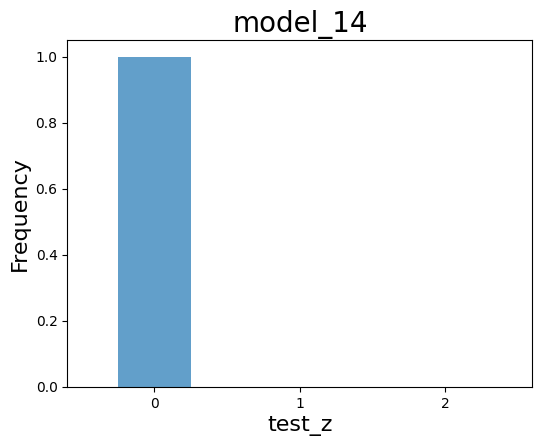

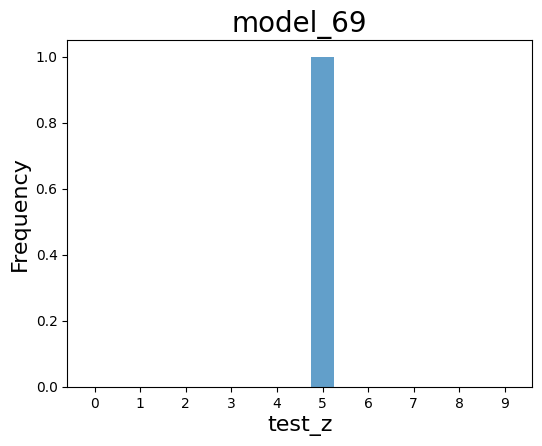

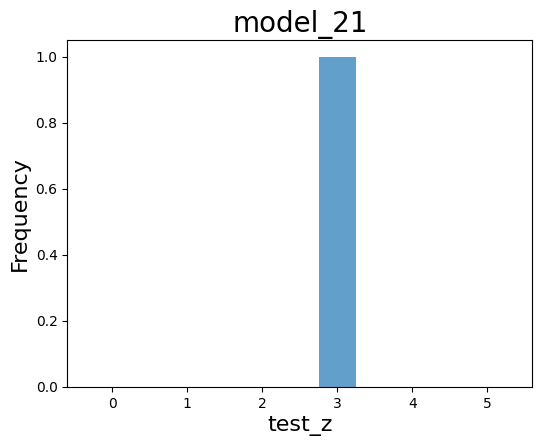

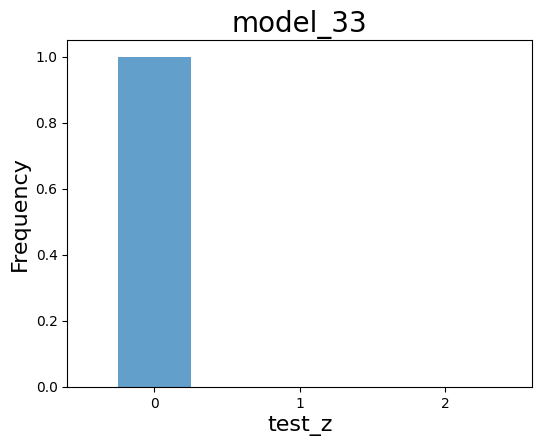

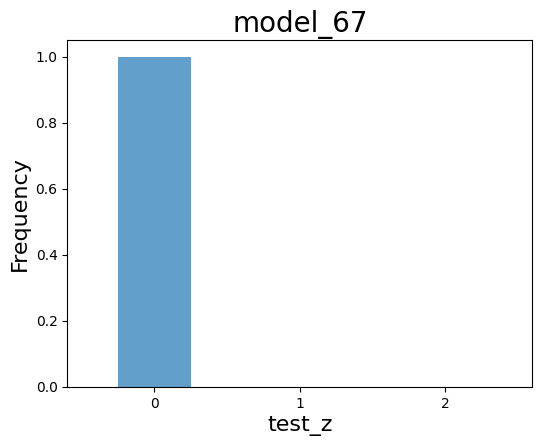

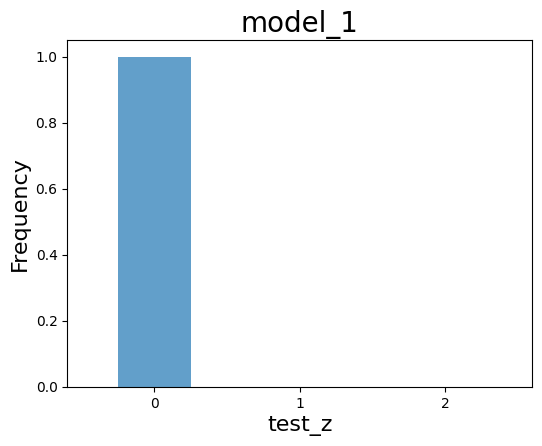

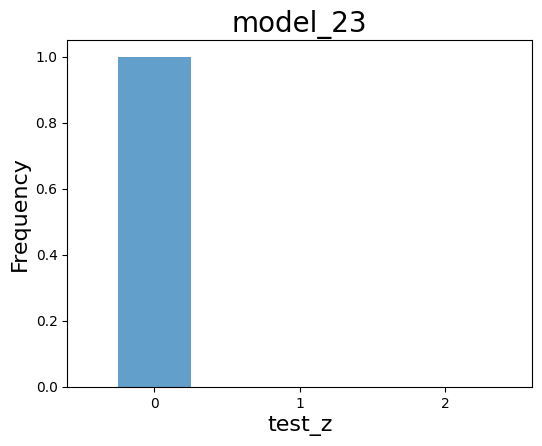

In [120]:
for p in paths_best:
    df = pd.read_csv(p)
    num = extract_number_after_p(p.split(os.sep)[-1])
    plt.figure(figsize=(6, 4.5))
    plt.hist(df['test_z'], bins=np.arange(-0.5, num, 1), alpha=0.7, rwidth=0.5, density=True)
    # plt.title(f'Histogram of test_z : {p.split(os.sep)[-2]}, n_latent_action = {num}', fontsize=16)
    plt.title(p.split(os.sep)[-2], fontsize=20)
    plt.xlabel('test_z', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(np.arange(0, num, 1))
    plt.xlim(-0.6, num-0.4)
    plt.show()

In [13]:
df

,Unnamed: 0,test_s_pos_x,test_s_pos_y,test_s_v_x,test_s_v_y,test_s_angle,test_s_w,test_s_next_pos_x,test_s_next_pos_y,test_s_next_v_x,...,test_s_next_angle,test_s_next_w,test_metric,test_z,rel_metric_pos_x,rel_metric_pos_y,rel_metric_v_x,rel_metric_v_y,rel_metric_angle,rel_metric_w
0,0,0.499784,0.977126,0.496715,0.544178,0.500120,0.500737,0.499675,0.980240,0.496715,...,0.500178,0.500736,0.034495,0,1.708598,0.000483,1.679779,133.015820,10.373733,100.767235
1,1,0.499675,0.980240,0.496715,0.541516,0.500178,0.500736,0.499567,0.983154,0.496715,...,0.500237,0.500736,0.034429,0,1.714039,0.002076,1.591680,131.929750,10.963545,100.612724
2,2,0.499567,0.983154,0.496715,0.538849,0.500237,0.500736,0.499459,0.985867,0.496715,...,0.500295,0.500736,0.034379,0,1.685823,0.014906,1.539654,131.442410,11.546159,100.668976
3,3,0.499459,0.985867,0.496715,0.536182,0.500295,0.500736,0.499351,0.988381,0.496715,...,0.500354,0.500736,0.034340,0,1.652996,0.043438,1.500817,131.007860,12.096795,100.847946
4,4,0.499351,0.988381,0.496715,0.533516,0.500354,0.500736,0.499242,0.990695,0.496715,...,0.500412,0.500736,0.034310,0,1.615608,0.093941,1.474502,130.626270,12.611954,101.150130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33981,33981,0.476900,0.499692,0.500000,0.500000,0.500092,0.500000,0.476900,0.499692,0.500000,...,0.500092,0.500000,0.012055,0,2.628245,0.034626,32.183064,104.448130,5.017936,1.022463
33982,33982,0.476900,0.499692,0.500000,0.500000,0.500092,0.500000,0.476900,0.499692,0.500000,...,0.500092,0.500000,0.012055,0,2.628245,0.034626,32.183037,104.448130,5.017935,1.022465
33983,33983,0.476900,0.499692,0.500000,0.500000,0.500092,0.500000,0.476900,0.499692,0.500000,...,0.500092,0.500000,0.012055,0,2.628245,0.034626,32.182995,104.448130,5.017939,1.022446
33984,33984,0.476900,0.499692,0.500000,0.500000,0.500092,0.500000,0.476900,0.499692,0.500000,...,0.500092,0.500000,0.012055,0,2.628245,0.034626,32.182980,104.448130,5.017930,1.022447
